In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from pathlib import Path
import pickle
from utils.lyric_tokenizer import base_tokenize

In [2]:
if os.name == "nt":
    plt.rcParams["font.family"] = "Meiryo"
elif os.name == "posix":
    plt.rcParams["font.family"] = "Hiragino Sans"

In [3]:
SEED = 65403

In [4]:
ROOT = Path("./").resolve().parent
SECRETS = ROOT / ".secrets"
DATA = ROOT / "data"
DATA.mkdir(exist_ok=True,parents=True)
BT_OUT =ROOT / "output" / "BERTopic_output_20251002101507"
RES = ROOT / "output/analysis"
RES.mkdir(exist_ok=True,parents=True)

In [5]:
def tknz(txt):
    KEEPPOS = {"名詞", "形容詞", "動詞", "代名詞", "連体詞", "感動詞"}
    NG = set("ない あ あぁ う この あの その ここ そこ する いる ある なる こと".split(" "))
    return base_tokenize(
        txt,
        keep_pos=KEEPPOS,
        ng_words=NG,
        )

In [6]:
df = pd.read_pickle(BT_OUT / "topic_results.pkl")

In [81]:
# 1) 埋め込みロード（shape = (n_songs, d) の ndarray を想定）
path = BT_OUT / "embeddings.pkl"
with open(path, "rb") as f:
    emb = pickle.load(f)
emb = np.asarray(emb, dtype=np.float64)
assert emb.ndim == 2, f"embeddings must be 2D, got {emb.shape}"

# 2) 曲ベクトルをL2正規化
emb_norm = emb / np.clip(np.linalg.norm(emb, axis=1, keepdims=True), 1e-9, None)
df["emb"] = list(emb_norm)  # 各行に1ベクトル（object列）

# 3) アーティスト重心（正規化後ベクトルの平均→再正規化）
centroids = (
    df.groupby("artist", sort=False)["emb"]  # 既存順でもOK。名前順にしたければ sort=True
      .apply(lambda xs: np.vstack(xs).mean(axis=0))
      .reset_index()
)

C = np.vstack(centroids["emb"].values)  # (n_artists, d)
C = C / np.clip(np.linalg.norm(C, axis=1, keepdims=True), 1e-9, None)
centroids["emb"] = list(C)

# 4) 欲しければ ndarray でも持っておく
artist_pool_df = centroids.rename(columns={"emb": "emb"})
artist_pool = C  # (n_artists, d)

# 5) 検証（長さ≈1か）
assert np.allclose(np.linalg.norm(emb_norm, axis=1), 1.0, atol=1e-5)
assert np.allclose(np.linalg.norm(artist_pool, axis=1), 1.0, atol=1e-5)


## PCA

In [82]:
from sklearn.decomposition import PCA

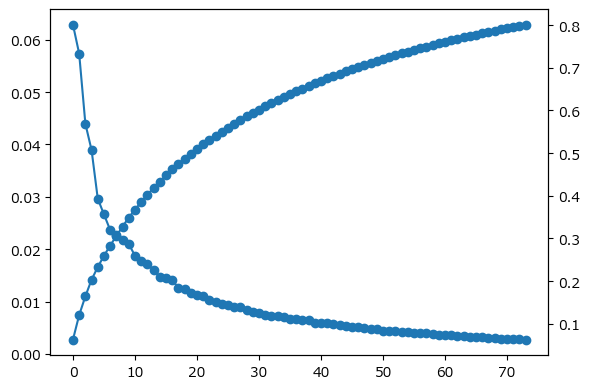

In [83]:
X = emb
y = df["title"].str.cat(df.artist)

pca = PCA(
    n_components=0.8,
    random_state=SEED
    )
X_pca = pca.fit_transform(emb_norm)
C_pca = pca.transform(artist_pool)
# 寄与率と累積寄与率
explained = pca.explained_variance_ratio_
cum_explained = explained.cumsum()
fig, ax = plt.subplots(
    figsize=(6, 4),
    tight_layout=True,
)
ax_ = ax.twinx()
ax.plot(np.arange(len(explained)),explained,"-o",label = "各主成分の寄与率")
ax_.plot(np.arange(len(explained)),cum_explained,"-o",label = "累積寄与率")

## UMAP

In [84]:
import umap

In [85]:
um = umap.UMAP(
    n_components=2,
    n_neighbors=25,
    min_dist=0.1,
    metric="cosine",
    random_state=SEED,
    )
X_2d = um.fit_transform(X_pca)
C_2d = um.transform(C_pca)

d:\koide\source\spotify_audio_feature\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## マッピング

In [9]:
import plotly.graph_objects as go

In [15]:
def topic_rgba(t,n_topic,cmap_mame="Set3"):
    """topic値に応じてRGBA文字列を返す。-1はグレー薄め"""
    cmap = plt.get_cmap("Set3", n_topic)
    if t >= 0:
        r, g, b, a = cmap(int(t))
        return f"rgba({int(r*255)},{int(g*255)},{int(b*255)},{0.9})"
    else:
        return "rgba(126,126,126,0.2)"

In [ ]:
# ========================
# 1) プロット用データフレーム整形
# ========================
cols = [
    "artist",
    "song",
    "topic",
    "X",
    "Y",
    "release",
    "lyricist",
    "color",
    "size",
    "alpha",
]

# --- 楽曲点 ---
song_plot_df = pd.DataFrame(columns=cols)
song_plot_df["X"] = X_2d[:, 0]
song_plot_df["Y"] = X_2d[:, 1]
song_plot_df["artist"] = df["artist"].values
song_plot_df["song"] = df["title"].values
song_plot_df["release"] = df["release"].values
song_plot_df["topic"] = df["topic"].values
song_plot_df["lyricist"] = df["lyricist"].values

# 色マップ（matplotlibのSet3をtopic数で刻む）
n_topic = int(df["topic"].max()) + 1

song_plot_df["color"] = song_plot_df["topic"].apply(lambda x:topic_rgba(x,n_topic))
song_plot_df["alpha"] = np.where(song_plot_df["topic"] >= 0, 0.7, 0.2)
song_plot_df["size"] = 8  # 曲点は小さめ

# --- アーティスト代表点（大きい赤円＋ラベル）---
artist_plot_df = pd.DataFrame(columns=cols)
artist_plot_df["X"] = C_2d[:, 0]
artist_plot_df["Y"] = C_2d[:, 1]
artist_plot_df["artist"] = artist_pool_df.artist.values
artist_plot_df["song"] = "representative"
artist_plot_df["color"] = "rgba(255,88,88,0.50)"  # 半透明の赤
artist_plot_df["alpha"] = 0.5
artist_plot_df["size"] = 18  # plotlyはピクセル指定。大きめに。

In [ ]:
# song_plot_df.to_pickle(RES/"UMAPed_song_df.pkl")
# artist_plot_df.dropna(how="all",axis=1).to_pickle(RES/"UMAPed_artist_df.pkl")

In [ ]:
# pd.merge(
#     song_plot_df[["artist","song","topic","X","Y","release","lyricist"]],
#     df[["artist","title","lyric"]],
#     'left',
#     left_on=["artist","song"],
#     right_on=["artist","title"],
# ).to_csv(RES / "song_df_tableau.csv", encoding='utf-8-sig',index=False)
# artist_plot_df[["artist","song","X","Y"]].to_csv(
#     RES / "artist_df_tableau.csv", encoding='utf-8-sig',index=False)

In [31]:
song_plot_df=pd.read_pickle(RES/"UMAPed_song_df.pkl")
artist_plot_df=pd.read_pickle(RES/"UMAPed_artist_df.pkl")

In [23]:
artists = artist_plot_df.artist.tolist()
artist_color = {name:topic_rgba(i,len(artists)) for i,name in enumerate(artists)}

In [28]:
# ========================
# 2) Plotlyで描画 アーティストで色分け
# ========================
fig = go.Figure()

# --- 楽曲点（大量想定なのでScattergl）---
song_custom = np.stack([
    song_plot_df["artist"],
    song_plot_df["song"],
    song_plot_df["release"].astype(str),
    song_plot_df["lyricist"].astype(str),
    song_plot_df["topic"].astype(str),
], axis=-1)

fig.add_trace(go.Scattergl(
    x=song_plot_df["X"],
    y=song_plot_df["Y"],
    mode="markers",
    name="Songs",
    marker=dict(
        size=song_plot_df["size"],
        color=song_plot_df["artist"].apply(lambda x:artist_color[x]),  # RGBA文字列で透過も反映
        line=dict(width=0),
    ),
    customdata=song_custom,
    hovertemplate=(
        "<b>%{customdata[0]}</b> - %{customdata[1]}<br>"
        "Release: %{customdata[2]}<br>"
        "Lyricist: %{customdata[3]}<br>"
        "Topic: %{customdata[4]}<extra></extra>"
    ),
))

# --- アーティスト点（テキスト表示）---
fig.add_trace(go.Scattergl(
    x=artist_plot_df["X"],
    y=artist_plot_df["Y"],
    mode="markers+text",
    name="Artists",
    text=artist_plot_df["artist"],
    textposition="top center",
    textfont=dict(size=11),
    marker=dict(
        size=artist_plot_df["size"],
        color=artist_plot_df["artist"].apply(lambda x:artist_color[x]),
        line=dict(width=1, color="rgba(0,0,0,0.25)")
    ),
    hovertemplate="<b>%{text}</b><br>representative<extra>Artist</extra>",
))

# --- トピック凡例を作る（ダミートレースをLegend用に追加）---
for artist in artists:
    fig.add_trace(go.Scattergl(
        x=[None], y=[None],
        mode="markers",
        name=artist if len(artist) < 20 else artist.split(" ")[0],
        marker=dict(size=10, color=artist_color[artist]),
        hoverinfo="skip",
        showlegend=True
    ))

# --- レイアウト ---
fig.update_layout(
    width=1200,
    height=800,
    template="simple_white",
    title="Songs & Artists Map (hover for details)",
    legend_title="Legend",
    hoverlabel=dict(bgcolor="rgba(255,255,255,0.95)"),
    margin=dict(l=40, r=40, t=60, b=40),
)
fig.update_xaxes(title="", showgrid=False, zeroline=False)
fig.update_yaxes(title="", showgrid=False, zeroline=False, scaleanchor="x", scaleratio=1)

fig.write_html(RES/"scatter_map_by_artist.html")
fig.show()


In [ ]:
# ========================
# 2) Plotlyで描画 トピックで色分け
# ========================
fig = go.Figure()

# --- 楽曲点（大量想定なのでScattergl）---
song_custom = np.stack([
    song_plot_df["artist"],
    song_plot_df["song"],
    song_plot_df["release"].astype(str),
    song_plot_df["lyricist"].astype(str),
    song_plot_df["topic"].astype(str),
], axis=-1)

fig.add_trace(go.Scattergl(
    x=song_plot_df["X"],
    y=song_plot_df["Y"],
    mode="markers",
    name="Songs",
    marker=dict(
        size=song_plot_df["size"],
        color=song_plot_df["color"],  # RGBA文字列で透過も反映
        line=dict(width=0),
    ),
    customdata=song_custom,
    hovertemplate=(
        "<b>%{customdata[0]}</b> - %{customdata[1]}<br>"
        "Release: %{customdata[2]}<br>"
        "Lyricist: %{customdata[3]}<br>"
        "Topic: %{customdata[4]}<extra></extra>"
    ),
))

# --- アーティスト点（テキスト表示）---
fig.add_trace(go.Scattergl(
    x=artist_plot_df["X"],
    y=artist_plot_df["Y"],
    mode="markers+text",
    name="Artists",
    text=artist_plot_df["artist"],
    textposition="top center",
    textfont=dict(size=11),
    marker=dict(
        size=artist_plot_df["size"],
        color=artist_plot_df["color"],
        line=dict(width=1, color="rgba(0,0,0,0.25)")
    ),
    hovertemplate="<b>%{text}</b><br>representative<extra>Artist</extra>",
))

# --- トピック凡例を作る（ダミートレースをLegend用に追加）---
unique_topics = sorted([t for t in song_plot_df["topic"].unique() if t >= 0])
for t in unique_topics:
    fig.add_trace(go.Scattergl(
        x=[None], y=[None],
        mode="markers",
        name=f"topic_{t}",
        marker=dict(size=10, color=topic_rgba(int(t),song_plot_df.topic.max())),
        hoverinfo="skip",
        showlegend=True
    ))
# -1(その他)用
if (song_plot_df["topic"] == -1).any():
    fig.add_trace(go.Scattergl(
        x=[None], y=[None],
        mode="markers",
        name="topic_-1 (other)",
        marker=dict(size=10, color=topic_rgba(-1,song_plot_df.topic.max())),
        hoverinfo="skip",
        showlegend=True
    ))

# --- レイアウト ---
fig.update_layout(
    width=1200,
    height=800,
    template="simple_white",
    title="Songs & Artists Map (hover for details)",
    legend_title="Legend",
    hoverlabel=dict(bgcolor="rgba(255,255,255,0.95)"),
    margin=dict(l=40, r=40, t=60, b=40),
)
fig.update_xaxes(title="", showgrid=False, zeroline=False)
fig.update_yaxes(title="", showgrid=False, zeroline=False, scaleanchor="x", scaleratio=1)

fig.write_html(RES/"scatter_map.html")
fig.show()


In [ ]:
song_plot_df

In [ ]:
artist = artists[0]
songs_x = song_plot_df.loc[song_plot_df.artist == artist,"X"].values
songs_y = song_plot_df.loc[song_plot_df.artist == artist,"Y"].values
color = song_plot_df.loc[song_plot_df.artist == artist,"color"].values



artist              song  topic         X         Y    release  \
0     back number          クリスマスソング     -1 -4.048950  5.113385 2015-11-18   
1     back number                花束      0 -3.136292  8.668666 2011-06-22   
2     back number           ハッピーエンド      0 -2.992734  8.077903 2016-11-16   
3     back number           高嶺の花子さん      0 -2.932649  8.555090 2013-06-26   
4     back number              ヒロイン      9 -4.230228  3.805984 2015-01-21   
...           ...               ...    ...       ...       ...        ...   
2445        浜崎あゆみ          STEP you     -1 -1.406246  8.659784 2005-04-20   
2446        浜崎あゆみ         ourselves      1 -1.220499  6.878252 2003-07-09   
2447        浜崎あゆみ        NEVER EVER     -1 -2.510084  5.873148 2001-03-07   
2448        浜崎あゆみ  Together When...     -1 -3.441348  7.864150 2007-12-05   
2449        浜崎あゆみ          Startin'      1 -1.233830  6.841680 2006-03-08   

            lyricist                  color  size  alpha  
0              清水依与吏  rgba(126,126,126,0.2)     8    0.2  
1              清水依与吏  rgba(141,211,199,0.9)     8    0.7  
2              清水依与吏  rgba(141,211,199,0.9)     8    0.7  
3              清水依与吏  rgba(141,211,199,0.9)     8    0.7  
4              清水依与吏  rgba(204,235,197,0.9)     8    0.7  
...              ...                    ...   ...    ...  
2445  ayumi hamasaki  rgba(126,126,126,0.2)     8    0.2  
2446  ayumi hamasaki  rgba(255,255,179,0.9)     8    0.7  
2447  ayumi hamasaki  rgba(126,126,126,0.2)     8    0.2  
2448  ayumi hamasaki  rgba(126,126,126,0.2)     8    0.2  
2449  ayumi hamasaki  rgba(255,255,179,0.9)     8    0.7  

[2450 rows x 10 columns]

In [ ]:
song_plot_df=pd.read_pickle(RES/"UMAPed_song_df.pkl")
artist_plot_df=pd.read_pickle(RES/"UMAPed_artist_df.pkl")

In [ ]:
# cmap = plt.get_cmap("Set3",df.topic.max()+1)
# fig, ax = plt.subplots(
#     figsize=(15, 10),
#     tight_layout=True,
# )
# t_x = X_2d[df.topic == -1]
# ax.scatter(t_x[:,0],t_x[:,1],color="#7E7E7E",alpha=.2)
# for t in np.arange(df.topic.max()+1):
#     t_x = X_2d[df.topic==t]
#     ax.scatter(t_x[:,0],t_x[:,1],color=cmap(t),alpha=.7,label=f"topic_{t}")
# ax.scatter(C_2d[:,0],C_2d[:,1],s=500,color="red",alpha=.5)
# for i,artist in enumerate(artists):
#     np.random.seed(i)
#     rnd = np.random.normal(0,0.05)
#     ax.text(C_2d[i,0]+rnd,C_2d[i,1]+rnd,s=artist,ha="center",va="center")
# ax.legend(
#     loc='upper left',
#     bbox_to_anchor=(1, 1),
#     ncol=1,
#     )

## wordcloud

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from matplotlib.colors import to_hex as hexcol

In [23]:
# --- アーティストごとに歌詞を結合（1アーティスト=1文書） ---
artist_docs = (
    df.assign(lyric=df["lyric"].fillna(""))
        .groupby("artist", sort=False)["lyric"]
        .apply(lambda s: "\n".join(map(str, s)))
)
artists = artist_docs.index.tolist()
corpus = artist_docs.tolist()

In [26]:
# --- TF-IDF ベクトライザ（外部トークナイザを使用） ---
# 重要: tokenizerを使うときは token_pattern=None / lowercase=False を推奨
vectorizer = TfidfVectorizer(
    tokenizer=tknz,
    preprocessor=None,
    token_pattern=None,
    lowercase=False,
    stop_words=None,
    min_df=1,
    max_df=0.95,
    # max_features=5000,
    sublinear_tf=True,       # TFをlogスケーリング
    norm="l2"                # コサイン類似の前処理として一般的
)
X = vectorizer.fit_transform(corpus)   # shape: (n_artists, n_terms)
vocab = np.array(vectorizer.get_feature_names_out())

# --- アーティストごとにWordCloud生成 ---
wc_by_artist: dict[str, WordCloud] = {}
for i, artist in enumerate(artists):
    row = X.getrow(i)
    idx = row.indices
    data = row.data
    freqs = {vocab[j]: float(w) for j, w in zip(idx, data)}

    # # 上位語の確認（任意）
    # if topn_preview and len(freqs) > 0:
    #     top_idx = np.argsort(-data)[:topn_preview]
    #     preview = [(vocab[idx[k]], float(data[k])) for k in top_idx]
    #     print(f"[{artist}] top terms:", ", ".join(f"{w}:{s:.3f}" for w,s in preview))

    wc = WordCloud(
        width=500,
        height=500,
        background_color="white",
        font_path=r"C:\Windows\Fonts\BIZ-UDGothicR.ttc",
        collocations=False,
        prefer_horizontal=1,
        min_font_size=8,
        max_words=30,
        # colormap=None,
    ).generate_from_frequencies(freqs)

    wc_by_artist[artist] = wc

In [32]:
def wc_recolor(wc,fontcolor):
    def single_color_func(
            word,
            font_size,
            position,
            orientation,
            random_state=None,
            **kwargs,
            ):
        return fontcolor
    wc.recolor(color_func=single_color_func)
    return wc

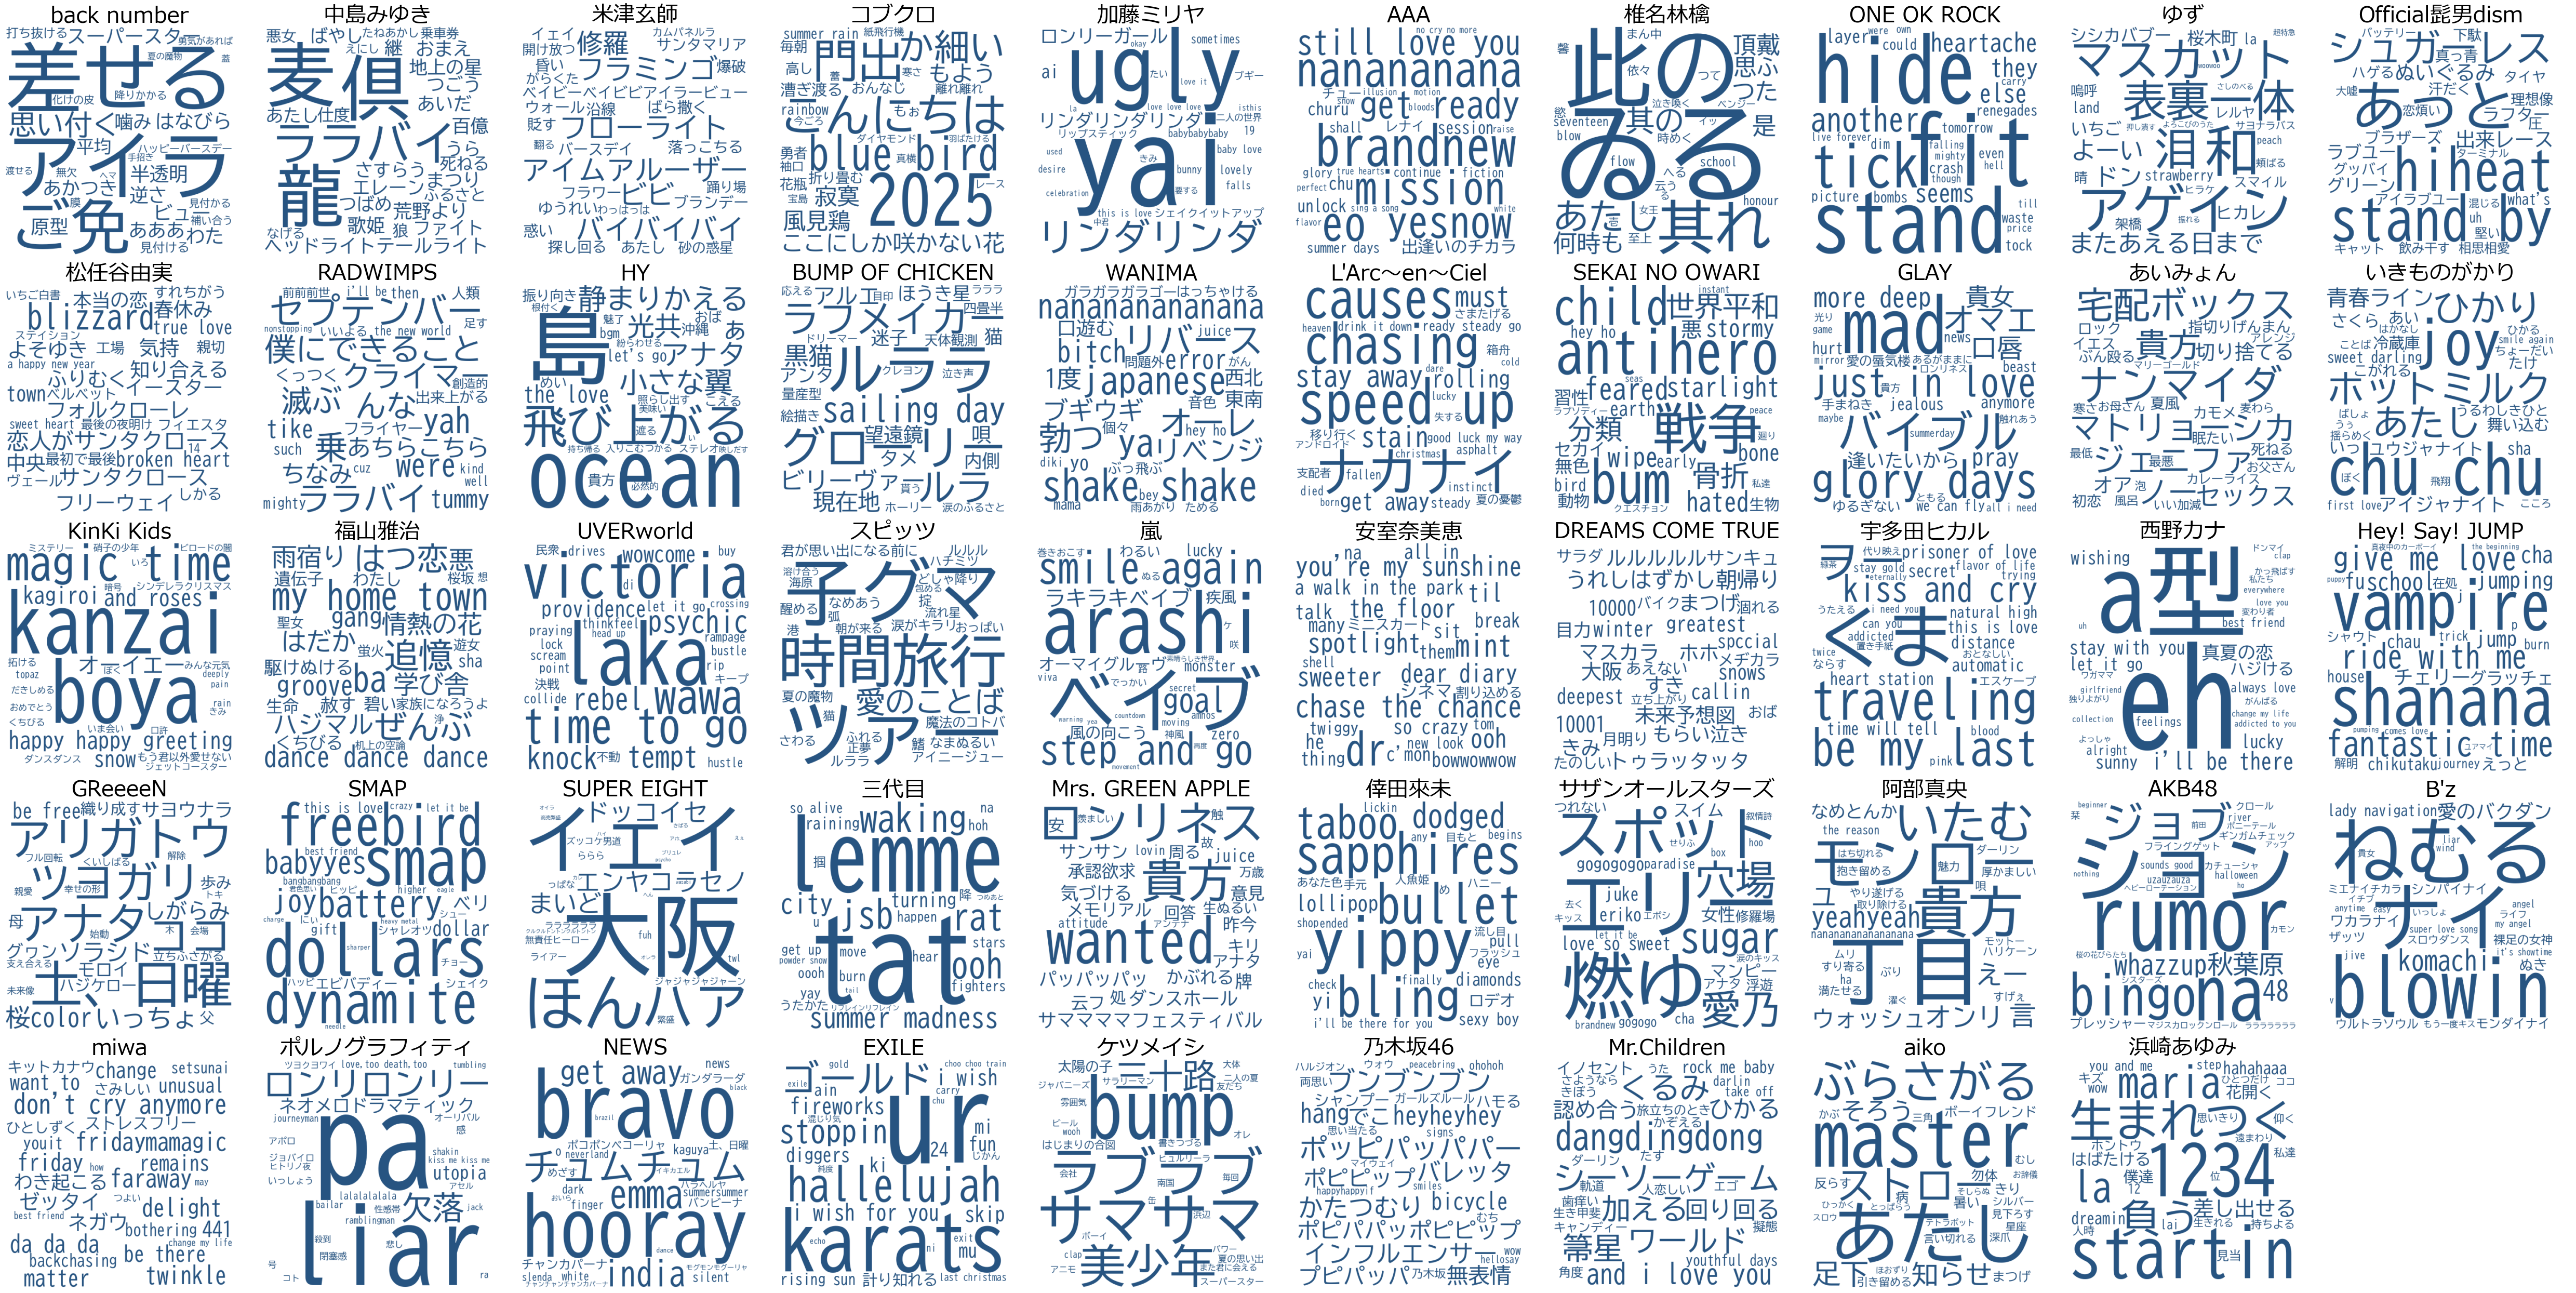

In [58]:
fig, axes = plt.subplots(
    nrows=5,
    ncols=10,
    figsize=(50, 25),
    tight_layout=True,
    sharex=False,
    sharey=False
)
axes = np.ravel(axes)
# cmap = plt.get_cmap("tab10", len(wc_by_artist))

for i, (artist,wc) in enumerate(wc_by_artist.items()):
    ax = axes[i]
    ax.imshow(
        wc_recolor(wc,"#275481"),
        interpolation="bilinear")
    artist_ = artist if len(artist) < 20 else artist.split(" ")[0]
    ax.set_title(artist_,fontsize =30)
for ax in axes:
    ax.axis("off")

ほかのアーティストと被らない、そのアーティスト特異的なワード

## コサイン距離

In [89]:
from sklearn.metrics.pairwise import cosine_distances

In [92]:
embeddings = np.vstack([emb_norm,artist_pool])
np.allclose(np.linalg.norm(embeddings, axis=1), 1.0, atol=1e-5)

True

In [93]:
# 全組み合わせ距離（対称行列）
D = cosine_distances(embeddings)

# 上三角だけ欲しい場合
i, j = np.triu_indices_from(D, k=1)
pairs = np.stack([i, j, D[i, j]], axis=1)

In [108]:
pair_df = pd.DataFrame(pairs,columns=["a_id","b_id","cos_dis"])

In [109]:
for tar in ["a", "b"]:
    pair_df[f"{tar}_artist"] = pair_df[f"{tar}_id"].apply(
        lambda x:df.artist[x] if x<len(df) else artist_pool_df.artist[x-len(df)]
        )
    pair_df[f"{tar}_song"] = pair_df[f"{tar}_id"].apply(
        lambda x:df.title[x] if x<len(df) else "representative"
        )

In [ ]:
pair_df["A"] = pair_df.a_artist + ":" + pair_df.a_song
pair_df["B"] = pair_df.b_artist + ":" + pair_df.b_song

In [118]:
pair_df = pair_df[
    [
        'A',
        'B',
        'cos_dis',
        'a_artist',
        'a_song',
        'b_artist',
        'b_song',
        'a_id',
        'b_id',
    ]
]
pair_df.to_pickle(RES / "cos_dist.pkl")

In [122]:
pair_df

A                     B   cos_dis  \
0              back number:クリスマスソング        back number:花束  0.666805   
1              back number:クリスマスソング   back number:ハッピーエンド  0.448732   
2              back number:クリスマスソング   back number:高嶺の花子さん  0.458288   
3              back number:クリスマスソング      back number:ヒロイン  0.388156   
4              back number:クリスマスソング        back number:瞬き  0.435906   
...                             ...                   ...       ...   
3121246        乃木坂46:representative   aiko:representative  0.079725   
3121247        乃木坂46:representative  浜崎あゆみ:representative  0.067491   
3121248  Mr.Children:representative   aiko:representative  0.060150   
3121249  Mr.Children:representative  浜崎あゆみ:representative  0.038116   
3121250         aiko:representative  浜崎あゆみ:representative  0.035609   

            a_artist          a_song     b_artist          b_song    a_id  \
0        back number        クリスマスソング  back number              花束     0.0   
1        back number        クリスマスソング  back number         ハッピーエンド     0.0   
2        back number        クリスマスソング  back number         高嶺の花子さん     0.0   
3        back number        クリスマスソング  back number            ヒロイン     0.0   
4        back number        クリスマスソング  back number              瞬き     0.0   
...              ...             ...          ...             ...     ...   
3121246        乃木坂46  representative         aiko  representative  2495.0   
3121247        乃木坂46  representative        浜崎あゆみ  representative  2495.0   
3121248  Mr.Children  representative         aiko  representative  2496.0   
3121249  Mr.Children  representative        浜崎あゆみ  representative  2496.0   
3121250         aiko  representative        浜崎あゆみ  representative  2497.0   

           b_id  
0           1.0  
1           2.0  
2           3.0  
3           4.0  
4           5.0  
...         ...  
3121246  2497.0  
3121247  2498.0  
3121248  2497.0  
3121249  2498.0  
3121250  2498.0  

[3121251 rows x 9 columns]

In [123]:
emb.shape

(2450, 768)

In [121]:
pair_df.sort_values("cos_dis",ascending=False)

A  \
2953565             AKB48:桜の花びらたち   
2943956            AKB48:フライングゲット   
611059             AAA:GAME OVER?   
2952406       AKB48:GIVE ME FIVE!   
1175518        松任谷由実:シンデレラ・エクスプレス   
...                           ...   
3121164       倖田來未:representative   
2653793            GReeeeN:weeeek   
2491249     宇多田ヒカル:FINAL DISTANCE   
605893                      AAA:虹   
3066003  EXILE:24karats STAY GOLD   

                                                         B       cos_dis  \
2953565                                     NEWS:ポコポンペコーリャ  1.104503e+00   
2943956                                      AKB48:桜の花びらたち  1.101812e+00   
611059                                          ケツメイシ:ドライブ  1.093594e+00   
2952406                                     NEWS:ポコポンペコーリャ  1.089556e+00   
1175518                                     NEWS:ポコポンペコーリャ  1.089125e+00   
...                                                    ...           ...   
3121164                                miwa:representative  1.888557e-02   
2653793                                        NEWS:weeeek  2.375593e-03   
2491249                                    宇多田ヒカル:DISTANCE  3.330669e-16   
605893                                           GReeeeN:虹  2.220446e-16   
3066003  EXILE:24karats STAY GOLD feat. 三代目 J Soul Brot...  0.000000e+00   

        a_artist              a_song b_artist  \
2953565    AKB48             桜の花びらたち     NEWS   
2943956    AKB48            フライングゲット    AKB48   
611059       AAA          GAME OVER?    ケツメイシ   
2952406    AKB48       GIVE ME FIVE!     NEWS   
1175518    松任谷由実        シンデレラ・エクスプレス     NEWS   
...          ...                 ...      ...   
3121164     倖田來未      representative     miwa   
2653793  GReeeeN              weeeek     NEWS   
2491249   宇多田ヒカル      FINAL DISTANCE   宇多田ヒカル   
605893       AAA                   虹  GReeeeN   
3066003    EXILE  24karats STAY GOLD    EXILE   

                                               b_song    a_id    b_id  
2953565                                     ポコポンペコーリャ  1919.0  2144.0  
2943956                                       桜の花びらたち  1903.0  1919.0  
611059                                           ドライブ   257.0  2227.0  
2952406                                     ポコポンペコーリャ  1917.0  2144.0  
1175518                                     ポコポンペコーリャ   525.0  2144.0  
...                                               ...     ...     ...  
3121164                                representative  2485.0  2490.0  
2653793                                        weeeek  1531.0  2102.0  
2491249                                      DISTANCE  1376.0  1378.0  
605893                                              虹   255.0  1544.0  
3066003  24karats STAY GOLD feat. 三代目 J Soul Brothers  2166.0  2197.0  

[3121251 rows x 9 columns]

In [ ]:

    if show:
        plt.figure(figsize=(width/100, height/100), dpi=100)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"{artist} — TF-IDF WordCloud")
        plt.show()

    if save_dir:
        out_path = os.path.join(save_dir, f"wordcloud_{artist}.png")
        wc.to_file(out_path)

In [22]:
df.groupby()

title       artist        lyricist       composer  \
0             クリスマスソング  back number           清水依与吏          清水依与吏   
1                   花束  back number           清水依与吏          清水依与吏   
2              ハッピーエンド  back number           清水依与吏          清水依与吏   
3              高嶺の花子さん  back number           清水依与吏          清水依与吏   
4                 ヒロイン  back number           清水依与吏          清水依与吏   
...                ...          ...             ...            ...   
2445          STEP you        浜崎あゆみ  ayumi hamasaki  Kazuhiro Hara   
2446         ourselves        浜崎あゆみ  ayumi hamasaki     BOUNCEBACK   
2447        NEVER EVER        浜崎あゆみ  ayumi hamasaki           CREA   
2448  Together When...        浜崎あゆみ  ayumi hamasaki     Kunio Tago   
2449          Startin'        浜崎あゆみ  ayumi hamasaki  Kazuhiro Hara   

                   arranger                            lyrics_url  \
0     back number・小林武史・四家卯大  https://www.uta-net.com/song/195484/   
1          島田昌典・back number  https://www.uta-net.com/song/113824/   
2          小林武史・back number  https://www.uta-net.com/song/216847/   
3         back number・蔦谷好位置  https://www.uta-net.com/song/147577/   
4          小林武史・back number  https://www.uta-net.com/song/177145/   
...                     ...                                   ...   
2445                   CMJK   https://www.uta-net.com/song/25903/   
2446                   CMJK   https://www.uta-net.com/song/17497/   
2447                          https://www.uta-net.com/song/12815/   
2448                          https://www.uta-net.com/song/58845/   
2449                          https://www.uta-net.com/song/37464/   

                                                  lyric    release  topic  \
0     どこかで鐘が鳴って らしくない言葉が浮かんで 寒さが心地よくて あれ なんで恋なんかしてんだ... 2015-11-18     -1   
1     どう思う？これから2人でやっていけると思う？ んんどうかなぁでもとりあえずは 一緒にいたいと... 2011-06-22      0   
2     さよならが喉の奥につっかえてしまって 咳をするみたいにありがとうって言ったの 次の言葉はどこ... 2016-11-16      0   
3     君から見た僕はきっと ただの友達の友達 たかが知人bにむけられた 笑顔があれならもう 恐ろし... 2013-06-26      0   
4     君の毎日に 僕は似合わないかな 白い空から 雪が落ちた 別にいいさと 吐き出したため息が 少... 2015-01-21      9   
...                                                 ...        ...    ...   
2445  どうって事ない会話のやり取り ふとした瞬間に見せる仕草 忘れないようにって思わなくても あた... 2005-04-20     -1   
2446  ぎゅっとしてみたり じんとしたり しゅんとしたり またぎゅっとしてみたり しゃんとしたり つ... 2003-07-09      1   
2447  いつか生まれる前からきっと 変わらないモノを探し続けては 見つけて 失って 時に 人をキズつ... 2001-03-07     -1   
2448  僕達は心に同じ 傷跡を残しながら 背を向けたまま振り返らずに そっと強く歩き出しました 変わ... 2007-12-05     -1   
2449  一体何の為に自分を恥じたりして ねぇその先には何があるの 僕はまっすぐすぎてすぐにぶつかる君... 2006-03-08      1   

          prob                                                emb  
0     0.000000  [-0.02706308, -0.0053655813, -0.01414998, 0.03...  
1     1.000000  [-0.014506752, -0.018582089, 0.018767595, -0.0...  
2     0.929285  [-0.04074722, -0.02706673, -0.011908229, 0.019...  
3     0.816192  [-0.03042236, 0.04887596, -0.038056035, -0.019...  
4     1.000000  [-0.029274667, 0.005526489, 0.00095040497, -0....  
...        ...                                                ...  
2445  0.000000  [-0.061215322, -0.00917993, 0.003464224, -0.08...  
2446  0.796617  [0.002421788, 0.0040712114, 0.014876613, -0.00...  
2447  0.000000  [-0.03881201, -0.015757618, -0.089804426, 0.02...  
2448  0.000000  [0.025393069, -0.024961196, -0.003377319, 0.01...  
2449  0.823710  [0.018673414, 0.044911336, -0.004930589, -0.01...  

[2450 rows x 11 columns]

In [ ]:
from utils.lyric_tokenizer import base_tokenize,_TOK

In [ ]:
m = _TOK.tokenize("楽園ではなくても 夢ではなくても この目で見てみたい ギターが刻むのは踊り子のステップ 銀の髪飾りを揺らしながらどこへと我をいざなう？ 呼びあう soul &")
for m_ in m:
    print(m_,m_.part_of_speech()[0])


In [ ]:
NG

In [ ]:
KEEPPOS = {"名詞", "形容詞", "動詞", "代名詞", "連体詞", "感動詞"}
NG = set("ない あ あぁ う この あの その ここ そこ する いる ある なる".split(" "))
i = np.random.choice(len(df))
ly = df.lyric[i].split(" ")
span = 6
to = span
for fr in range(0,len(ly),span):
    print(" ".join(ly[fr:to]))
    print(base_tokenize(" ".join(ly[fr:to]),keep_pos=KEEPPOS,ng_words=NG,max_chars_per_chunk=40000,hard_max_chars=45000))
    to += span